In [1]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt

import qujax

# Let's start with a circuit specification

We also store the number of parameters in the circuit, as we will need this later.

In [2]:
def get_circuit(n_qubits, depth):
    
    n_params = 2 * n_qubits * (depth + 1)
    
    
    gates = ['H'] * n_qubits + ['Rx'] * n_qubits + ['Ry'] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]
    
    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append('CZ')
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append('Rx')
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append('Ry')
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params

In [3]:
n_qubits = 4
depth = 2

In [4]:
gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, depth)

In [5]:
print(gates)
print(len(gates))

['H', 'H', 'H', 'H', 'Rx', 'Rx', 'Rx', 'Rx', 'Ry', 'Ry', 'Ry', 'Ry', 'CZ', 'CZ', 'CZ', 'Rx', 'Rx', 'Rx', 'Rx', 'Ry', 'Ry', 'Ry', 'Ry', 'CZ', 'CZ', 'CZ', 'Rx', 'Rx', 'Rx', 'Rx', 'Ry', 'Ry', 'Ry', 'Ry']
34


In [6]:
print(qubit_inds)
print(len(qubit_inds))

[[0], [1], [2], [3], [0], [1], [2], [3], [0], [1], [2], [3], [0, 1], [1, 2], [2, 3], [0], [1], [2], [3], [0], [1], [2], [3], [0, 1], [1, 2], [2, 3], [0], [1], [2], [3], [0], [1], [2], [3]]
34


In [7]:
print(param_inds)
print(len(param_inds))

[[], [], [], [], [0], [1], [2], [3], [4], [5], [6], [7], [], [], [], [8], [9], [10], [11], [12], [13], [14], [15], [], [], [], [16], [17], [18], [19], [20], [21], [22], [23]]
34


Looks good, and all the list lengths are the same 😎

We can also print the circuit to be sure it's what we intended

In [8]:
qujax.print_circuit(gates, qubit_inds, param_inds, gate_ind_max=30);

q0: -----H-----Rx[0]---Ry[4]-----◯-------------Rx[8]---Ry[12]------------◯-------------Rx[16]--Ry[20]
                                 |                                       |                           
q1: -----H-----Rx[1]---Ry[5]-----CZ------◯-----Rx[9]---Ry[13]------------CZ------◯-----Rx[17]--------
                                         |                                       |                   
q2: -----H-----Rx[2]---Ry[6]-------------CZ------◯-----Rx[10]--Ry[14]------------CZ------◯-----Rx[18]
                                                 |                                       |           
q3: -----H-----Rx[3]---Ry[7]---------------------CZ----Rx[11]--Ry[15]--------------------CZ----Rx[19]


# Now let's invoke qujax

The `qujax.get_params_to_statetensor_func` function will generate a parameters -> statetensor function for us.

Note that this function also has an optional second argument where an initiating `statetensor_in` can be provided. If it is not provided it will default to the all 0s state (as we use here).

Be aware that we still have convention where parameters are specified as multiples of $\pi$ - that is in [0,2].

In [9]:
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)

Let's try it out on some random parameters values. Be aware that's JAX's random number generator requires a `jax.random.PRNGkey` every time it's called - more info on that [here](https://jax.readthedocs.io/en/latest/jax.random.html).

In [10]:
params = random.uniform(random.PRNGKey(0), shape=(n_params,), minval=0., maxval=2.)
statetensor = param_to_st(params)
statetensor.shape

(2, 2, 2, 2)

We can obtain statevector by simply calling `.flatten()`

In [11]:
statevector = statetensor.flatten()
statevector.shape

(16,)

And sampling probabilities by squaring the absolute value of the statevector

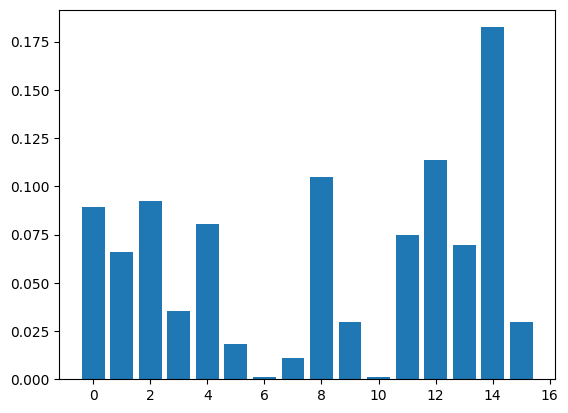

In [12]:
sample_probs = jnp.square(jnp.abs(statevector))
plt.bar(jnp.arange(statevector.size), sample_probs);

# Cost function

Now we have our `param_to_st` function we are free to define a cost function that acts on bitstrings (e.g. maxcut) or integers by directly wrapping a function around `param_to_st`. However, cost functions defined via quantum Hamiltonians are a bit more involved.

Fortunately, we can encode an Hamiltonian in JAX via the `qujax.get_statetensor_to_expectation_func` function which generates a statetensor -> expected value function for us.

It takes three arguments as input
- `gate_seq_seq`: A list of string (or array) lists encoding the gates in each term of the Hamiltonian. I.e. `[['X','X'], ['Y','Y'], ['Z','Z']]` corresponds to $H = aX_iX_j +  bY_kY_l + cZ_mZ_n$ with qubit indices $i,j,k,l,m,n$ specified in the second argument and coefficients $a,b,c$ specified in the third argument
- `qubit_inds_seq`: A list of integer lists encoding which qubit indices to apply the aforementioned gates. I.e. `[[0, 1],[0,1],[0,1]]`. Must have the same structure as `gate_seq_seq` above.
- `coefficients`: A list of floats encoding any coefficients in the Hamiltonian. I.e. `[2.3, 0.8, 1.2]` corresponds to $a=2.3,b=0.8,c=1.2$ above. Must have the same length as the two above arguments.

More specifically let's consider the problem of finding the ground state of the quantum Heisenberg Hamiltonian
$$
H = \sum_{i=1}^{n_\text{qubits}-1} X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1}.
$$
As described, we define the Hamiltonian via its gate strings, qubit indices and coefficients.

In [13]:
hamiltonian_gates = [['X', 'X'], ['Y', 'Y'], ['Z', 'Z']] * (n_qubits - 1)
hamiltonian_qubit_inds = [[int(i), int(i) + 1] for i in jnp.repeat(jnp.arange(n_qubits), 3)]
coefficients = [1.] * len(hamiltonian_qubit_inds) 

In [14]:
print('Gates:\t', hamiltonian_gates)
print('Qubits:\t', hamiltonian_qubit_inds)
print('Coefficients:\t', coefficients)

Gates:	 [['X', 'X'], ['Y', 'Y'], ['Z', 'Z'], ['X', 'X'], ['Y', 'Y'], ['Z', 'Z'], ['X', 'X'], ['Y', 'Y'], ['Z', 'Z']]
Qubits:	 [[0, 1], [0, 1], [0, 1], [1, 2], [1, 2], [1, 2], [2, 3], [2, 3], [2, 3], [3, 4], [3, 4], [3, 4]]
Coefficients:	 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Now let's get the Hamiltonian as a pure JAX function

In [15]:
st_to_expectation = qujax.get_statetensor_to_expectation_func(hamiltonian_gates,
                                                             hamiltonian_qubit_inds,
                                                             coefficients)

Let's check it works on the statetensor we've already generated.

In [16]:
expected_val = st_to_expectation(statetensor)
expected_val

Array(1.6290706, dtype=float32)

Now let's wrap the `param_to_st` and `st_to_expectation` together to give us an all in one `param_to_expectation` cost function.

In [17]:
param_to_expectation = lambda param: st_to_expectation(param_to_st(param))

In [18]:
param_to_expectation(params)

Array(1.6290706, dtype=float32)

Sanity check that a different, randomly generated set of parameters gives us a new expected value.

In [19]:
new_params = random.uniform(random.PRNGKey(1), shape=(n_params,), minval=0., maxval=2.)
param_to_expectation(new_params)

Array(0.2565445, dtype=float32)

# We can now use autodiff for fast, exact gradients within a VQE algorithm

The `param_to_expectation` function we created is a pure JAX function and outputs a scalar. This means we can pass it to `jax.grad` (or even better `jax.value_and_grad`).

In [20]:
cost_and_grad = value_and_grad(param_to_expectation)

The `cost_and_grad` function returns a tuple with the exact cost value and exact gradient evaluated at the parameters.

In [21]:
cost_and_grad(params)

(Array(1.6290706, dtype=float32),
 Array([ 9.3626761e-07,  5.6176054e-07,  6.0857394e-07,  4.6813381e-07,
         2.5579420e-01,  9.2308128e-01, -2.2530050e+00, -2.1122539e+00,
         1.7944418e+00,  5.6182927e-01, -1.0677941e+00, -1.7813085e-01,
         5.0560904e-01, -1.4611506e+00,  5.2151042e-01, -2.5418801e+00,
         4.8420203e-01, -7.3182994e-01,  1.4512728e-01,  1.4524205e-01,
         5.1464313e-01, -5.8293301e-01, -9.7354606e-02,  1.6564427e-01],      dtype=float32))

# Now we have all the tools we need to design our VQE!

We'll just use vanilla gradient descent with a constant stepsize

In [22]:
def vqe(init_param, n_steps, stepsize):
    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(n_steps)
    cost_vals = cost_vals.at[0].set(param_to_expectation(init_param))
    
    for step in range(1, n_steps):
        cost_val, cost_grad = cost_and_grad(params[step - 1])
        cost_vals = cost_vals.at[step].set(cost_val)

        new_param = params[step - 1] - stepsize * cost_grad
        params = params.at[step].set(new_param)

        print('Iteration:', step, '\tCost:', cost_val, end='\r')
    print('\n')
    return params, cost_vals

Ok enough talking, let's run (and whilst we're at it we'll time it too)

In [23]:
%time vqe_params, vqe_cost_vals = vqe(params, n_steps=250, stepsize=0.01)

Iteration: 249 	Cost: -6.32724666.323721

CPU times: user 22.3 s, sys: 245 ms, total: 22.5 s
Wall time: 22.4 s


Let's plot the results...

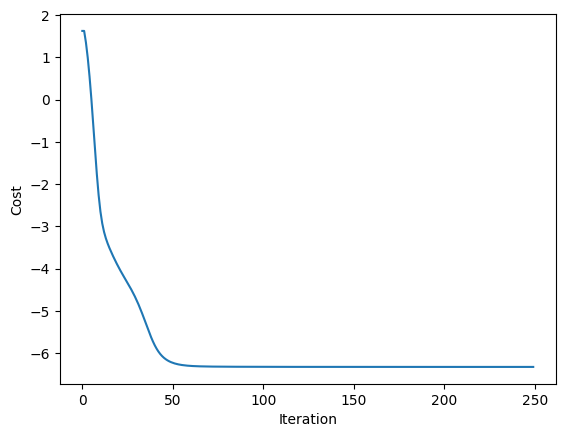

In [24]:
plt.plot(vqe_cost_vals)
plt.xlabel('Iteration')
plt.ylabel('Cost');

Pretty good!

# `jax.jit` speedup

One last thing... We can significantly speed up the VQE above via the `jax.jit`. In our current implementation, the expensive `cost_and_grad` function is compiled to [XLA](https://www.tensorflow.org/xla)  and then executed at each call. By invoking `jax.jit` we ensure that the function is compiled only once (on the first call) and then simply executed at each future call - this is much faster!

In [25]:
cost_and_grad = jit(cost_and_grad)

We'll demonstrate this using the second set of initial parameters we randomly generated (to be sure of no caching).

In [26]:
%time new_vqe_params, new_vqe_cost_vals = vqe(new_params, n_steps=250, stepsize=0.01)

Iteration: 249 	Cost: -6.3270717

CPU times: user 1.65 s, sys: 23.9 ms, total: 1.67 s
Wall time: 1.22 s


That's some speedup!

But let's also plot the training to be sure it converged correctly

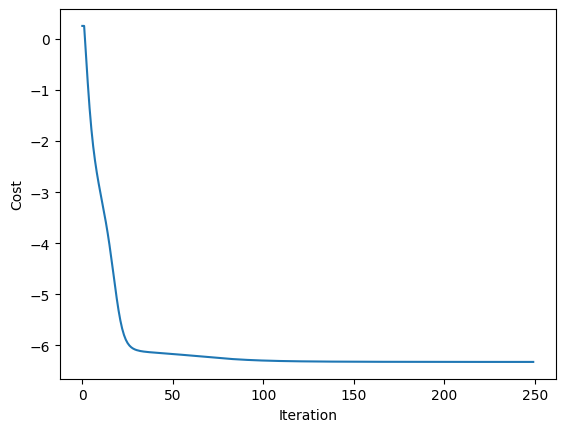

In [27]:
plt.plot(new_vqe_cost_vals)
plt.xlabel('Iteration')
plt.ylabel('Cost');